In [11]:
!pip install scikit-learn

  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------- ----------------------------- 2.4/8.7 MB 12.6 MB/s eta 0:00:01
   ------------------------------- -------- 6.8/8.7 MB 17.5 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 18.0 MB/s  0:00:00
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---- ----------------------------------- 4.7/38.5 MB 21.7 MB/s eta 0:00:02
   ---------- ----------------------------- 10.5/38.5 MB 25.5 MB/s eta 0:00:02
   ---------------- ----------------------- 16.3/38.5 MB 26.1 MB/s eta 0:00:01
   ---------------------- ----------------- 21.8/38.5 MB 26.3 MB/s eta 0:00:01
   ---------------------------- ----------- 27.3/38.5 MB 26.5 MB/s eta 0:00:01
   --------------------------------- ------ 32.5/38.5 M

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [21]:
# Step 1 — Load the data
DATA_PATH = "https://raw.githubusercontent.com/OmDeokar/Group-Data-Analysis-Presentation-2025-2026/main/Dataset/SMHS_general-1.csv"   # change if needed
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
df.head()


Loaded: https://raw.githubusercontent.com/OmDeokar/Group-Data-Analysis-Presentation-2025-2026/main/Dataset/SMHS_general-1.csv
Shape: (1500, 29)


,id,age,sex,ethnicity,latent_cluster,deprivation_index,smoking_status,alcohol_units_week,physical_activity_minutes,diet_quality_score,...,fasting_glucose,fasting_insulin,triglycerides,hdl,ldl,crp,alt,shift_worker,family_history_diabetes,metabolic_pressure
0,1,56,F,White,3,74.968216,Former,NaN,92.872646,60.614177,...,7.367951,21.589497,2.607227,0.737260,2.704100,28.432087,37.267948,No,0,73.087968
1,2,59,M,White,2,34.912176,Never,NaN,26.103352,72.107270,...,6.717636,16.379792,3.112712,1.654086,3.750358,1.624550,29.042661,No,0,59.541750
2,3,49,M,Black,2,54.207211,Former,NaN,210.401582,49.249182,...,5.052053,17.104307,4.525291,1.031543,3.812500,2.236999,33.364052,No,1,54.864634
3,4,39,F,White,2,27.870993,Never,NaN,214.605575,61.195129,...,6.018634,21.739572,1.322513,1.232799,4.086235,NaN,22.496442,No,0,49.199538
4,5,45,F,Other,3,72.684155,Never,21.249861,135.063492,49.828539,...,5.826059,16.918793,2.312573,1.014607,3.390955,5.999061,51.853812,No,0,70.674299


In [36]:
def cat_var(df):
    cat_vars = df.select_dtypes(include='object').columns.tolist()
    print("\nCategorical variables:", cat_vars)
    for c in cat_vars:
        print(f"\nUnique values in {c}:")
        print(df[c].unique())
cat_var(df)


Categorical variables: ['sex', 'ethnicity', 'smoking_status', 'shift_worker']

Unique values in sex:
['F' 'M']

Unique values in ethnicity:
['White' 'White ' 'Black' 'Other ' 'SouthAsian' 'SouthAsian ' ' ' 'Other'
 'Black ' '  ']

Unique values in smoking_status:
['Former' 'Never' 'Current' 'Ne^ver' 'Nev*er' 'F+ormer' 'Nev_er'
 '.Current']

Unique values in shift_worker:
['No' 'Yes']


In [27]:
df_clean = df.copy()

# --- Clean ethnicity ---
df_clean['ethnicity'] = df_clean['ethnicity'].str.strip()

# Replace blanks or spaces with NaN
df_clean['ethnicity'] = df_clean['ethnicity'].replace(['', ' ', '  '], np.nan)

# Standardize categories
df_clean['ethnicity'] = df_clean['ethnicity'].replace({
    'White ': 'White',
    'Black ': 'Black',
    'Other ': 'Other',
    'SouthAsian ': 'SouthAsian'
})

# --- Clean smoking_status ---
df_clean['smoking_status'] = df_clean['smoking_status'].str.strip()

df_clean['smoking_status'] = df_clean['smoking_status'].replace({
    'Ne^ver': 'Never',
    'Nev*er': 'Never',
    'Nev_er': 'Never',
    '.Current': 'Current',
    'F+ormer': 'Former'
})

# --- Verify cleaning ---
print("Cleaned ethnicity:", df_clean['ethnicity'].unique())
print("Cleaned smoking_status:", df_clean['smoking_status'].unique())


Cleaned ethnicity: ['White' 'Black' 'Other' 'SouthAsian' nan]
Cleaned smoking_status: ['Former' 'Never' 'Current']


In [37]:
cat_var(df_clean)


Categorical variables: ['sex', 'ethnicity', 'smoking_status', 'shift_worker']

Unique values in sex:
['F' 'M']

Unique values in ethnicity:
['White' 'Black' 'Other' 'SouthAsian' nan]

Unique values in smoking_status:
['Former' 'Never' 'Current']

Unique values in shift_worker:
['No' 'Yes']


In [42]:
df=df_clean
df.nunique()

id                           1500
age                            61
sex                             2
ethnicity                       4
latent_cluster                  4
deprivation_index            1497
smoking_status                  3
alcohol_units_week            241
physical_activity_minutes    1479
diet_quality_score           1494
depression_score             1402
bmi                          1500
waist_hip_ratio              1500
sbp                          1500
dbp                          1500
sleep_duration_hours         1497
sleep_variability_hours      1418
sleep_efficiency             1484
steps_per_day                1284
fasting_glucose              1500
fasting_insulin              1463
triglycerides                1499
hdl                          1500
ldl                          1500
crp                          1376
alt                          1499
shift_worker                    2
family_history_diabetes         2
metabolic_pressure           1500
dtype: int64

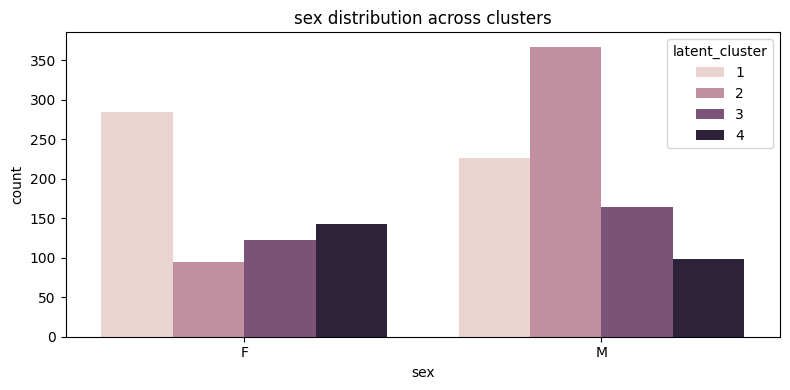

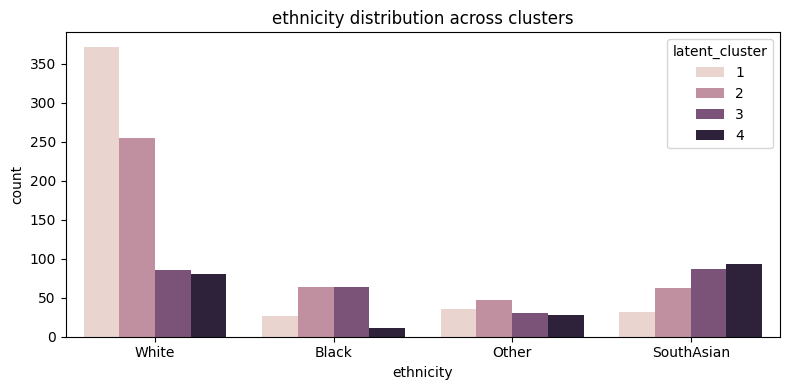

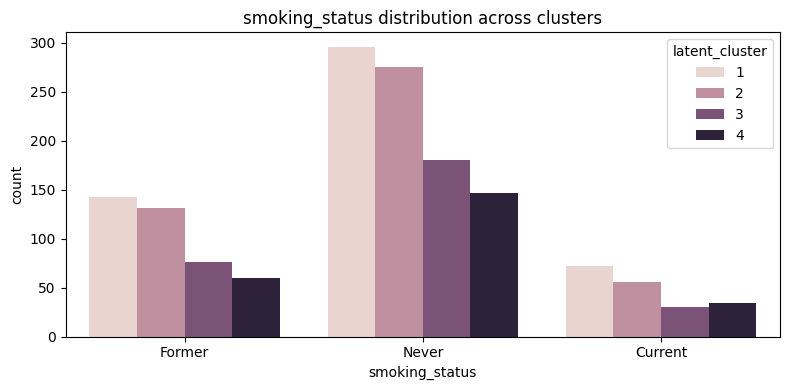

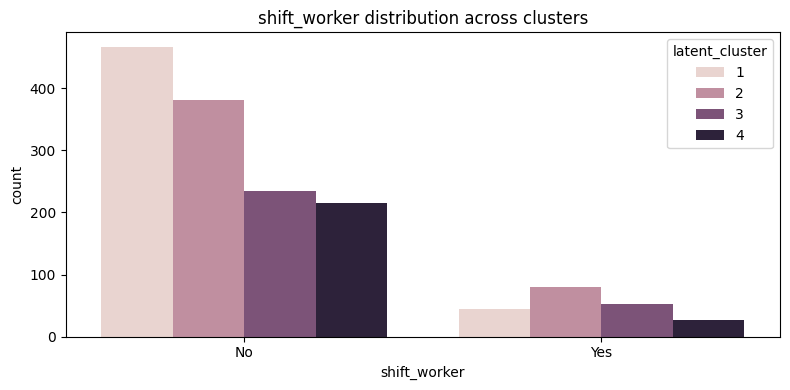

In [51]:
cat_vars = ['sex', 'ethnicity', 'smoking_status', 'shift_worker']

for c in cat_vars:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=c, hue='latent_cluster')
    plt.title(f"{c} distribution across clusters")
    plt.tight_layout()
    plt.savefig(f"cluster_distribution {c}.pdf")
    plt.show()

In [53]:
df["shift_worker"] = df["shift_worker"].astype(str).str.strip()

# ---------- SHIFT WORKER ----------
print("\n=== SHIFT WORKER: COUNTS BY CLUSTER ===")
shift_counts = pd.crosstab(df["latent_cluster"], df["shift_worker"])
print(shift_counts)

print("\n=== SHIFT WORKER: PERCENTAGES BY CLUSTER ===")
shift_pct = (shift_counts.div(shift_counts.sum(axis=1), axis=0) * 100).round(2)
print(shift_pct)

# ---------- SMOKING STATUS ----------
print("\n=== SMOKING STATUS: COUNTS BY CLUSTER ===")
smoke_counts = pd.crosstab(df["latent_cluster"], df["smoking_status"])
print(smoke_counts)

print("\n=== SMOKING STATUS: PERCENTAGES BY CLUSTER ===")
smoke_pct = (smoke_counts.div(smoke_counts.sum(axis=1), axis=0) * 100).round(2)
print(smoke_pct)


=== SHIFT WORKER: COUNTS BY CLUSTER ===
shift_worker     No  Yes
latent_cluster          
1               467   44
2               382   80
3               234   52
4               215   26

=== SHIFT WORKER: PERCENTAGES BY CLUSTER ===
shift_worker       No    Yes
latent_cluster              
1               91.39   8.61
2               82.68  17.32
3               81.82  18.18
4               89.21  10.79

=== SMOKING STATUS: COUNTS BY CLUSTER ===
smoking_status  Current  Former  Never
latent_cluster                        
1                    72     143    296
2                    56     131    275
3                    30      76    180
4                    34      60    147

=== SMOKING STATUS: PERCENTAGES BY CLUSTER ===
smoking_status  Current  Former  Never
latent_cluster                        
1                 14.09   27.98  57.93
2                 12.12   28.35  59.52
3                 10.49   26.57  62.94
4                 14.11   24.90  61.00


In [54]:
# Loop through and print percentages
for c in cat_vars:
    print("\n\n==============================")
    print(f"PERCENTAGE DISTRIBUTION FOR: {c}")
    print("==============================\n")

    # counts
    ct = pd.crosstab(df["latent_cluster"], df[c], dropna=False)
    print("COUNTS:\n", ct.to_string())

    # percentages
    pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(2)
    print("\nPERCENTAGES:\n", pct.to_string())



PERCENTAGE DISTRIBUTION FOR: sex

COUNTS:
 sex               F    M
latent_cluster          
1               285  226
2                95  367
3               122  164
4               143   98

PERCENTAGES:
 sex                 F      M
latent_cluster              
1               55.77  44.23
2               20.56  79.44
3               42.66  57.34
4               59.34  40.66


PERCENTAGE DISTRIBUTION FOR: ethnicity

COUNTS:
 ethnicity       Black  Other  SouthAsian  White  NaN
latent_cluster                                      
1                  27     35          32    372   45
2                  64     47          62    255   34
3                  64     31          87     85   19
4                  11     28          93     81   28

PERCENTAGES:
 ethnicity       Black  Other  SouthAsian  White    NaN
latent_cluster                                        
1                5.28   6.85        6.26  72.80   8.81
2               13.85  10.17       13.42  55.19   7.36
3           

In [44]:
num_vars = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_vars].describe().T


,count,mean,std,min,25%,50%,75%,max
id,1500.0,750.500000,433.157015,1.000000,375.750000,750.500000,1125.250000,1500.000000
age,1500.0,50.485333,12.509601,-40.000000,44.000000,51.000000,57.000000,340.000000
latent_cluster,1500.0,2.171333,1.070238,1.000000,1.000000,2.000000,3.000000,4.000000
deprivation_index,1500.0,49.182916,18.374494,0.000000,35.593492,49.296179,61.855031,100.000000
alcohol_units_week,259.0,10.353186,7.080095,0.000000,5.080323,9.400864,15.068977,32.150393
physical_activity_minutes,1500.0,197.559683,99.386868,0.000000,126.448868,192.707793,267.064538,525.749363
diet_quality_score,1500.0,68.636518,14.129799,27.513452,57.983449,69.408418,79.152142,100.000000
depression_score,1500.0,6.066072,3.926731,0.000000,3.071509,5.821105,8.789526,20.376602
bmi,1500.0,28.818955,6.303675,16.303238,23.137802,28.302516,34.767180,43.363405
waist_hip_ratio,1500.0,0.881543,0.070999,0.711217,0.826480,0.871866,0.932467,1.110629


In [45]:
suspicious = {}

for col in num_vars:
    low = df[col].min()
    high = df[col].max()
    suspicious[col] = (low, high)

pd.DataFrame(suspicious, index=["min","max"]).T


,min,max
id,1.000000,1500.000000
age,-40.000000,340.000000
latent_cluster,1.000000,4.000000
deprivation_index,0.000000,100.000000
alcohol_units_week,0.000000,32.150393
physical_activity_minutes,0.000000,525.749363
diet_quality_score,27.513452,100.000000
depression_score,0.000000,20.376602
bmi,16.303238,43.363405
waist_hip_ratio,0.711217,1.110629


In [46]:
df_clean['age'] = df_clean['age'].mask((df_clean['age'] < 0) | (df_clean['age'] > 120), np.nan)

print("Age summary after cleaning:")
print(df_clean['age'].describe())


Age summary after cleaning:
count    1498.000000
mean       50.352470
std         9.758127
min        19.000000
25%        44.000000
50%        51.000000
75%        57.000000
max        80.000000
Name: age, dtype: float64


In [47]:
df_clean['age'].min(), df_clean['age'].max()


(np.float64(19.0), np.float64(80.0))

In [26]:
required = [
    "latent_cluster",
    "metabolic_pressure",
    "bmi", "fasting_glucose", "fasting_insulin",
    "triglycerides", "hdl", "ldl",
    "alt", "crp",
    "sex", "smoking_status", "shift_worker"
]

print("\nRequired variables check:")
for r in required:
    print(r, "✓" if r in df.columns else "✗ NOT FOUND")



Required variables check:
latent_cluster ✓
metabolic_pressure ✓
bmi ✓
fasting_glucose ✓
fasting_insulin ✓
triglycerides ✓
hdl ✓
ldl ✓
alt ✓
crp ✓
sex ✓
smoking_status ✓
shift_worker ✓


In [52]:
# Step 2 — Quick checks: dtypes, missingness, target & cluster presence
pd.set_option("display.max_columns", 200)
print("Columns and dtypes:")
display(df.dtypes.reset_index().rename(columns={"index":"column", 0:"dtype"}))

print("\nTop missingness (%):")
display((df.isnull().mean() * 100).round(2).sort_values(ascending=False).head(40))

# Check target and cluster
print("\nmetabolic_pressure present?", "metabolic_pressure" in df.columns)
print("latent_cluster present?", "latent_cluster" in df.columns)
if "latent_cluster" in df.columns:
    print("Cluster counts:")
    display(df["latent_cluster"].value_counts(dropna=False))


Columns and dtypes:


,column,dtype
0,id,int64
1,age,float64
2,sex,object
3,ethnicity,object
4,latent_cluster,int64
5,deprivation_index,float64
6,smoking_status,object
7,alcohol_units_week,float64
8,physical_activity_minutes,float64
9,diet_quality_score,float64



Top missingness (%):


alcohol_units_week           82.73
steps_per_day                14.40
ethnicity                     8.40
crp                           8.07
sleep_variability_hours       4.60
fasting_insulin               2.47
age                           0.13
smoking_status                0.00
physical_activity_minutes     0.00
latent_cluster                0.00
deprivation_index             0.00
sex                           0.00
id                            0.00
waist_hip_ratio               0.00
bmi                           0.00
depression_score              0.00
diet_quality_score            0.00
sleep_duration_hours          0.00
dbp                           0.00
sleep_efficiency              0.00
sbp                           0.00
fasting_glucose               0.00
triglycerides                 0.00
hdl                           0.00
ldl                           0.00
alt                           0.00
shift_worker                  0.00
family_history_diabetes       0.00
metabolic_pressure  


metabolic_pressure present? True
latent_cluster present? True
Cluster counts:


latent_cluster
1    511
2    462
3    286
4    241
Name: count, dtype: int64